# Pneumonia Detection from x-rays
- Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli. The alveoli fill with fluid or pus, making it difficult to breathe.

https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851az

- This link is to guide how to download dataset directly from Kaggle.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
## this is the path where kaggle.json is present in the Google Drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle"

In [4]:
!pwd

/content


In [5]:
##changing the working directory
%cd /content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle

/content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle


In [6]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle


In [7]:
# # this is the pythnon API Command for dowload dataset, uncomment below line for download data
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [8]:
# checking files in working directory
!ls

chest_xray  kaggle.json


In [9]:
# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip

_________________________

________________________

In [10]:
# checking gpu details
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10063254698787877166, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7426680664401854350
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [29]:
# Required libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import pickle
from tensorflow.math import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152

img_size = (224,224)

In [12]:
data_path = "/content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle/chest_xray/" # where the data set is located

train_path = data_path + 'train/'
test_path = data_path +'test/'
val_path = data_path + 'val/'

## Visualization

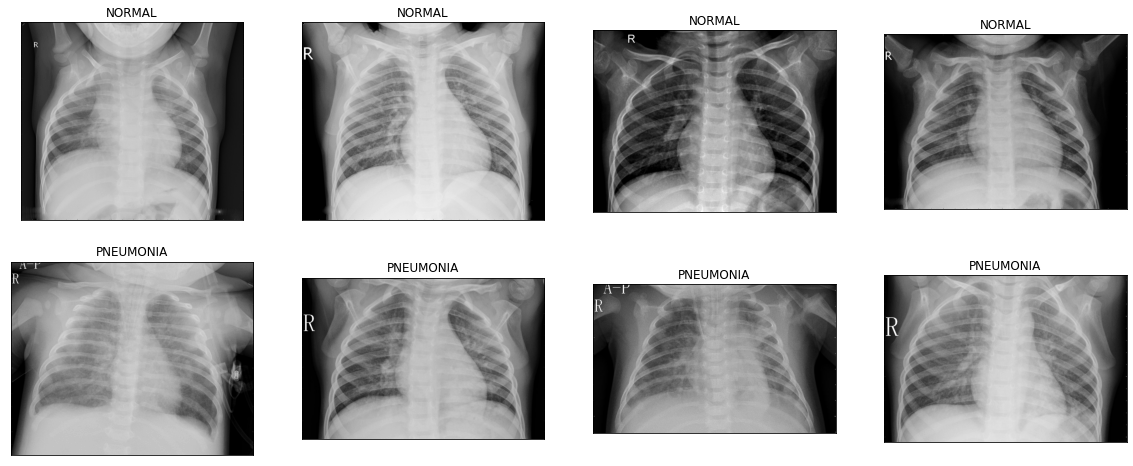

In [13]:
fig, ax = plt.subplots(nrows=2,ncols=4,figsize=(20, 8))
for i,cls in enumerate(os.listdir(val_path)):
  for j,image in enumerate(os.listdir(val_path+cls)[:4]):
    ax[i,j].set_title(cls)
    img  = plt.imread(val_path+cls+'/'+image)
    ax[i,j].imshow(img, cmap='gray')
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
plt.show()

In [ ]:
# def load_data(dir_path, img_size):
  
#     x = []
#     y = []
#     i = 0
#     labels = dict()
#     for path in tqdm(sorted(os.listdir(dir_path))):
#         if not path.startswith('.'):
#             labels[i] = path
#             for image in os.listdir(dir_path + path):
#                 if not image.startswith('.'):
#                     img = cv2.imread(dir_path + path + '/' + image)
#                     img = img.astype('float32') / 255
#                     resized = cv2.resize(img, img_size, interpolation = cv2.INTER_AREA)
#                     x.append(resized)
#                     y.append(i)
#             i += 1
#     x = np.array(x)
#     y = np.array(y)
#     print(f'{len(x)} images loaded from {dir_path} directory.')
#     return x, y, labels

In [ ]:
# # Loading train data
# x_train, y_train, train_labels = load_data(train_path, img_size)

100%|██████████| 2/2 [30:25<00:00, 912.92s/it]


5216 images loaded from /content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle/chest_xray/train/ directory.


In [ ]:
# # Loading validation data
# x_val, y_val, val_labels = load_data(val_path, img_size)

100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

16 images loaded from /content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle/chest_xray/val/ directory.


In [ ]:
# # Loading test data
# x_test, y_test, test_labels = load_data(test_path, img_size)

100%|██████████| 2/2 [03:26<00:00, 103.39s/it]

624 images loaded from /content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle/chest_xray/test/ directory.


In [ ]:
# # Use this to save variables
# path = "/content/gdrive/MyDrive/Colab Notebooks/Internship/Pneumonia/"
# with open(path+'pneumonia_data.pickle', 'wb') as f:
#     pickle.dump((x_train, x_val,x_test, y_train,y_val,y_test), f)

In [13]:
# Use this to load variables
pickel_path ="/content/gdrive/MyDrive/Colab Notebooks/Internship/Pneumonia/pneumonia_data.pickle"
with open(pickel_path, 'rb') as f:
    (x_train, x_val,x_test, y_train,y_val,y_test) = pickle.load(f)

In [14]:
x_train.shape, x_val.shape,x_test.shape, y_train.shape,y_val.shape,y_test.shape

((5216, 224, 224, 3),
 (16, 224, 224, 3),
 (624, 224, 224, 3),
 (5216,),
 (16,),
 (624,))

### DataFrame Creation

In [17]:
# Data Frame Creation for train data
train_x = x_train.reshape(x_train.shape[0],-1)
train_y = y_train.reshape(y_train.shape[0],-1)
pd.DataFrame(np.concatenate((train_x,train_y),axis=1)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,150489,150490,150491,150492,150493,150494,150495,150496,150497,150498,150499,150500,150501,150502,150503,150504,150505,150506,150507,150508,150509,150510,150511,150512,150513,150514,150515,150516,150517,150518,150519,150520,150521,150522,150523,150524,150525,150526,150527,150528
0,0.222160,0.222160,0.222160,0.254925,0.254925,0.254925,0.275752,0.275752,0.275752,0.288247,0.288247,0.288247,0.297780,0.297780,0.297780,0.298551,0.298551,0.298551,0.306074,0.306074,0.306074,0.324727,0.324727,0.324727,0.330425,0.330425,0.330425,0.340180,0.340180,0.340180,0.346052,0.346052,0.346052,0.345780,0.345780,0.345780,0.342989,0.342989,0.342989,0.353717,...,0.213590,0.213590,0.213590,0.152070,0.152070,0.152070,0.093069,0.093069,0.093069,0.049078,0.049078,0.049078,0.007032,0.007032,0.007032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.430541,0.430541,0.430541,0.376165,0.376165,0.376165,0.363392,0.363392,0.363392,0.374236,0.374236,0.374236,0.361474,0.361474,0.361474,0.376642,0.376642,0.376642,0.382433,0.382433,0.382433,0.384424,0.384424,0.384424,0.392793,0.392793,0.392793,0.388825,0.388825,0.388825,0.390525,0.390525,0.390525,0.389199,0.389199,0.389199,0.382024,0.382024,0.382024,0.424827,...,0.359120,0.359120,0.359120,0.236006,0.236006,0.236006,0.116337,0.116337,0.116337,0.084243,0.084243,0.084243,0.038183,0.038183,0.038183,0.006861,0.006861,0.006861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012616,0.012616,0.012616,0.047563,0.047563,0.047563,0.086536,0.086536,0.086536,0.130268,0.130268,0.130268,0.184953,0.184953,0.184953,0.232376,0.232376,0.232376,0.261871,0.261871,0.261871,0.310181,0.310181,0.310181,0.350808,0.350808,0.350808,0.376699,0.376699,0.376699,0.397023,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.343043,0.343043,0.343043,0.322665,0.322665,0.322665,0.314751,0.314751,0.314751,0.309881,0.309881,0.309881,0.288692,0.288692,0.288692,0.267375,0.267375,0.267375,0.253742,0.253742,0.253742,0.252658,0.252658,0.252658,0.238839,0.238839,0.238839,0.217497,0.217497,0.217497,0.179550,0.179550,0.179550,0.167067,0.167067,0.167067,0.195096,0.195096,0.195096,0.200347,...,0.039594,0.039594,0.039594,0.023646,0.023646,0.023646,0.000633,0.000633,0.000633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.092326,0.092326,0.092326,0.119808,0.119808,0.119808,0.153719,0.153719,0.153719,0.185421,0.185421,0.185421,0.197098,0.197098,0.197098,0.210084,0.210084,0.210084,0.275575,0.275575,0.275575,0.426216,0.426216,0.426216,0.420422,0.420422,0.420422,0.430092,0.430092,0.430092,0.424439,0.424439,0.424439,0.422616,0.422616,0.422616,0.444040,0.444040,0.444040,0.442903,...,0.623989,0.623989,0.623989,0.581184,0.581184,0.581184,0.434144,0.434144,0.434144,0.413358,0.413358,0.413358,0.362502,0.362502,0.362502,0.246994,0.246994,0.246994,0.195289,0.195289,0.195289,0.127762,0.127762,0.127762,0.079079,0.079079,0.079079,0.03102,0.03102,0.03102,0.001135,0.001135,0.001135,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Data Frame Creation for validation data
val_x = x_val.reshape(x_val.shape[0],-1)
val_y = y_val.reshape(y_val.shape[0],-1)
pd.DataFrame(np.concatenate((val_x,val_y),axis=1)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,150489,150490,150491,150492,150493,150494,150495,150496,150497,150498,150499,150500,150501,150502,150503,150504,150505,150506,150507,150508,150509,150510,150511,150512,150513,150514,150515,150516,150517,150518,150519,150520,150521,150522,150523,150524,150525,150526,150527,150528
0,0.261167,0.261167,0.261167,0.224281,0.224281,0.224281,0.297531,0.297531,0.297531,0.082129,0.082129,0.082129,0.065376,0.065376,0.065376,0.060051,0.060051,0.060051,0.053072,0.053072,0.053072,0.111003,0.111003,0.111003,0.148051,0.148051,0.148051,0.159000,0.159000,0.159000,0.170110,0.170110,0.170110,0.252371,0.252371,0.252371,0.194077,0.194077,0.194077,0.209148,...,0.108070,0.108070,0.108070,0.120092,0.120092,0.120092,0.128337,0.128337,0.128337,0.17026,0.17026,0.17026,0.144917,0.144917,0.144917,0.13464,0.13464,0.13464,0.155476,0.155476,0.155476,0.143430,0.143430,0.143430,0.149516,0.149516,0.149516,0.126991,0.126991,0.126991,0.115262,0.115262,0.115262,0.105338,0.105338,0.105338,0.103675,0.103675,0.103675,0.0
1,0.277562,0.277562,0.277562,0.217750,0.217750,0.217750,0.348013,0.348013,0.348013,0.341108,0.341108,0.341108,0.366540,0.366540,0.366540,0.386019,0.386019,0.386019,0.415801,0.415801,0.415801,0.436042,0.436042,0.436042,0.463161,0.463161,0.463161,0.471503,0.471503,0.471503,0.480540,0.480540,0.480540,0.491194,0.491194,0.491194,0.495186,0.495186,0.495186,0.498064,...,0.000705,0.000705,0.000705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.026974,0.026974,0.026974,0.055236,0.055236,0.055236,0.098625,0.098625,0.098625,0.124462,0.124462,0.124462,0.121535,0.121535,0.121535,0.114802,0.114802,0.114802,0.146958,0.146958,0.146958,0.145222,0.145222,0.145222,0.154168,0.154168,0.154168,0.164574,0.164574,0.164574,0.159955,0.159955,0.159955,0.153693,0.153693,0.153693,0.153890,0.153890,0.153890,0.154761,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.402040,0.402040,0.402040,0.254843,0.254843,0.254843,0.419443,0.419443,0.419443,0.303290,0.303290,0.303290,0.215339,0.215339,0.215339,0.153053,0.153053,0.153053,0.112438,0.112438,0.112438,0.112262,0.112262,0.112262,0.110774,0.110774,0.110774,0.101226,0.101226,0.101226,0.124279,0.124279,0.124279,0.169750,0.169750,0.169750,0.085316,0.085316,0.085316,0.079719,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.037722,0.037722,0.037722,0.001905,0.001905,0.001905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.209227,0.209227,0.209227,0.203909,0.203909,0.203909,0.105582,0.105582,0.105582,0.081041,0.081041,0.081041,0.104114,0.104114,0.104114,0.129891,0.129891,0.129891,0.161418,0.161418,0.161418,0.220507,0.220507,0.220507,0.252708,0.252708,0.252708,0.269803,0.269803,0.269803,0.285588,0.285588,0.285588,0.319659,0.319659,0.319659,0.357561,0.357561,0.357561,0.393878,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


### Ploting for majority and minority classes count

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


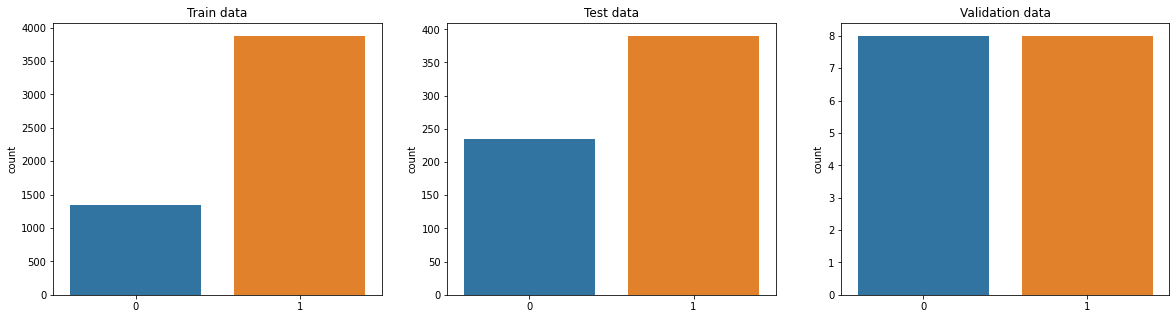

In [20]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(y_train)
plt.title('Train data')

plt.subplot(1,3,2);
sns.countplot(y_test)
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(y_val)
plt.title('Validation data')
plt.show()

## Data Augmentation

In [15]:
# normalization , basically image pixel values are 0 to 255
train = ImageDataGenerator(rescale=1./255,rotation_range=90,
                           zoom_range=0.2,
                           width_shift_range=0.2,
                           height_shift_range = 0.2,
                           horizontal_flip = True
                           ) # for traing data
validation = ImageDataGenerator(rescale=1./255,rotation_range=90,
                           zoom_range=0.2,
                           width_shift_range=0.2,
                           height_shift_range = 0.2,
                           horizontal_flip = True) # for validation data
test = ImageDataGenerator(rescale=1./255)

In [18]:
# for generating classes for traing data
train_data = train.flow_from_directory(directory=train_path,batch_size=32,# while traing NN
                                       target_size=img_size,
                                       class_mode='binary')# for generating classes

# for va;idation dataset
val_data = validation.flow_from_directory(directory=val_path,
                                          target_size=img_size,
                                          batch_size=32,
                                          class_mode="binary")
test_data = test.flow_from_directory(test_path,
                                          target_size=img_size,
                                          batch_size=32,
                                          class_mode="binary")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
train_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Model Building
  ### CNN

In [20]:
model = None
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),input_shape=(224, 224, 3)))
# conv3
model.add(Conv2D(64, kernel_size=(3, 3), 
                 padding='same', 
                 activation='relu', 
                 ))
model.add(MaxPooling2D(pool_size=(2, 2)))
# conv3-128
model.add(Conv2D(128, (3, 3),
                 activation='relu',
                 ))
# Maxpooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# conv3-128
model.add(Conv2D(256, (3, 3),
                 activation='relu',
                 ))
# Maxpooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# conv3-128
model.add(Conv2D(1024, (3, 3),
                 activation='relu',
                 ))
# Maxpooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flatten
model.add(Flatten())
# FC-1
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 256)       0

In [21]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [22]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1,mode='auto')
callback = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_data,epochs=30,batch_size=32, validation_data=val_data,callbacks=[lr_reduce,callback])

Epoch 1/30
163/163 [==============================] - 1477s 9s/step - loss: 0.5840 - accuracy: 0.7314 - val_loss: 1.4950 - val_accuracy: 0.5625
Epoch 2/30
163/163 [==============================] - 112s 689ms/step - loss: 0.4178 - accuracy: 0.7880 - val_loss: 1.3370 - val_accuracy: 0.5000
Epoch 3/30
163/163 [==============================] - 111s 678ms/step - loss: 0.3991 - accuracy: 0.8067 - val_loss: 2.5198 - val_accuracy: 0.6250
Epoch 4/30
163/163 [==============================] - 110s 673ms/step - loss: 0.3952 - accuracy: 0.8237 - val_loss: 1.8075 - val_accuracy: 0.6250
Epoch 5/30
163/163 [==============================] - 110s 672ms/step - loss: 0.3557 - accuracy: 0.8369 - val_loss: 1.6631 - val_accuracy: 0.5000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/30
163/163 [==============================] - 110s 671ms/step - loss: 0.2963 - accuracy: 0.8734 - val_loss: 2.1470 - val_accuracy: 0.5000
Epoch 7/30
163/163 [=========================

In [23]:
loss, accu = model.evaluate(x_test,y_test)
print(f"Loss : {loss}\nAccuracy : {accu}")

20/20 [==============================] - 1s 57ms/step - loss: 0.3624 - accuracy: 0.8365
Loss : 0.3623792827129364
Accuracy : 0.8365384340286255


In [25]:
pred = model.predict(x_test)
y_pred = [1 if x>0.5 else 0 for x in pred]

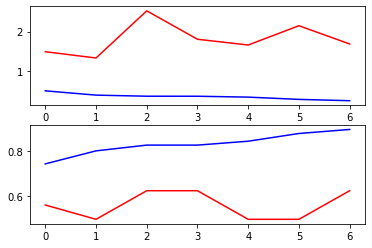

In [26]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

tf.Tensor(
[[192  42]
 [ 60 330]], shape=(2, 2), dtype=int32)


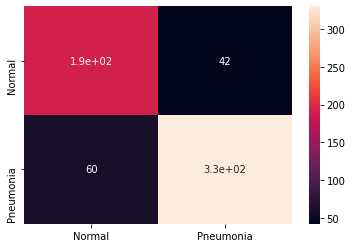

In [27]:
cm = confusion_matrix(y_test,y_pred,num_classes=2)
print(cm)
sns.heatmap(cm,annot=True,xticklabels=['Normal', 'Pneumonia'],yticklabels=['Normal', 'Pneumonia'])

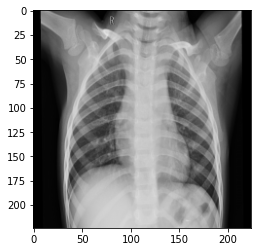

PNEUMONIA


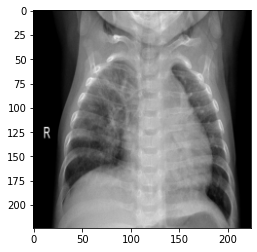

PNEUMONIA


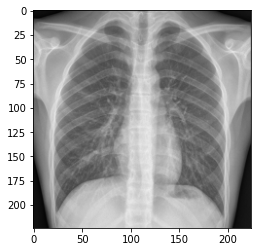

NORMAL


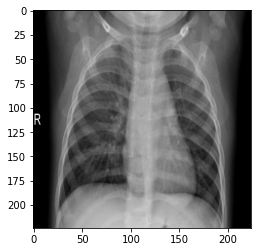

NORMAL


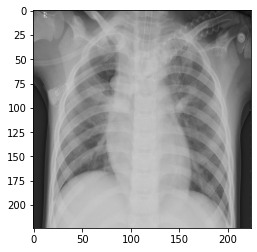

PNEUMONIA


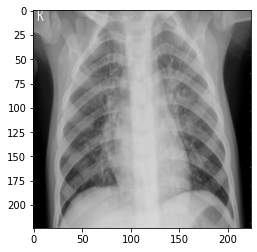

PNEUMONIA


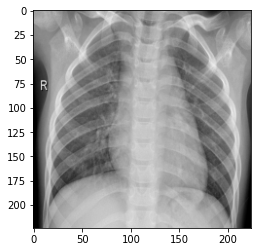

NORMAL


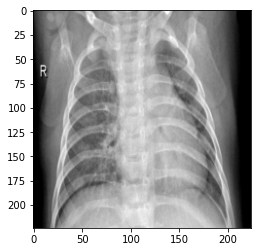

NORMAL


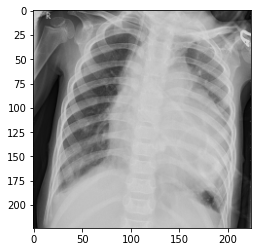

PNEUMONIA


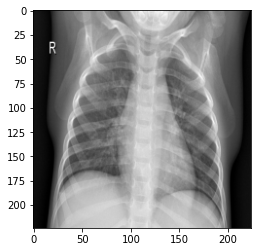

NORMAL


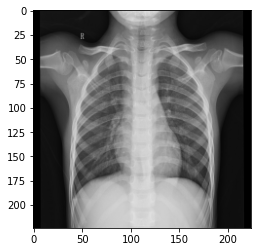

NORMAL


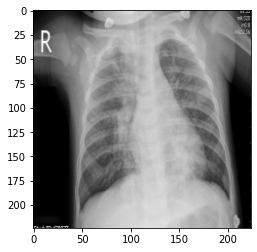

PNEUMONIA


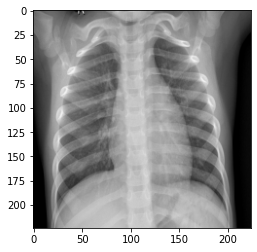

NORMAL


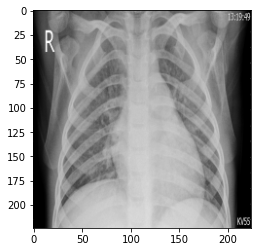

PNEUMONIA


In [ ]:
# Printing random test images with oredicting class
indices = np.random.choice(len(x_test), 14)
for i in indices:
  plt.imshow(x_test[i])
  plt.imshow(x_test[i])
  plt.show()
  x = np.expand_dims(x_test[i],axis=0)
  images = np.vstack([x])
  val = model.predict(images)
  val = [1 if x>0.5 else 0 for x in val]
  if val[0] == 0:
    print('NORMAL')
  else:
    print('PNEUMONIA')

## VGG16

In [30]:
vgg16 = VGG16(include_top=False,weights=None,
              input_shape=(224,224,3))

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)             

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1,mode='auto')
callback = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_data,epochs=30,batch_size=32, validation_data=val_data,steps_per_epoch=len(train_data),callbacks=[lr_reduce,callback])

In [ ]:
loss, accu = model.evaluate(x_test,y_test)
print(f"Loss : {loss}\nAccuracy : {accu}")

In [ ]:
pred = model.predict(x_test)
y_pred = [1 if x>0.5 else 0 for x in pred]

In [ ]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [ ]:
cm = confusion_matrix(y_test,y_pred,num_classes=2)
sns.heatmap(cm,annot=True,xticklabels=['Normal', 'Pneumonia'],yticklabels=['Normal', 'Pneumonia'])

In [ ]:
# Printing random images
indices = np.random.choice(len(x_test), 14)
for i in indices:
  plt.imshow(x_test[i])
  plt.imshow(x_test[i])
  plt.show()
  x = np.expand_dims(x_test[i],axis=0)
  images = np.vstack([x])
  val = model.predict(images)
  val = [1 if x>0.5 else 0 for x in val]
  if val[0] == 0:
    print('NORMAL')
  else:
    print('PNEUMONIA')

## Resnet 50

In [33]:
# Create model
model = None
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights=None))
model.add(Dense(1, activation='sigmoid'))

# Do not train first layer (ResNet) as it is already pre-trained
model.layers[0].trainable = False

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1,mode='auto')
callback = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_data,epochs=30,batch_size=32, validation_data=val_data,callbacks=[lr_reduce,callback])

In [ ]:
loss, accu = model.evaluate(x_test,y_test)
print(f"Loss : {loss}\nAccuracy : {accu}")

In [ ]:
pred = model.predict(x_test)
y_pred = [1 if x>0.5 else 0 for x in pred]

In [ ]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [ ]:
cm = confusion_matrix(y_test,y_pred,num_classes=2)
sns.heatmap(cm,annot=True,xticklabels=['Normal', 'Pneumonia'],yticklabels=['Normal', 'Pneumonia'])

In [ ]:
# Printing random images
indices = np.random.choice(len(x_test), 14)
for i in indices:
  plt.imshow(x_test[i])
  plt.imshow(x_test[i])
  plt.show()
  x = np.expand_dims(x_test[i],axis=0)
  images = np.vstack([x])
  val = model.predict(images)
  val = [1 if x>0.5 else 0 for x in val]
  if val[0] == 0:
    print('NORMAL')
  else:
    print('PNEUMONIA')

## RestNet 152

In [35]:
# Create model
model = None
model = Sequential()
model.add(ResNet152(include_top=False, pooling='max', weights=None))
model.add(Dense(1, activation='sigmoid'))

# Do not train first layer (ResNet) as it is already pre-trained
model.layers[0].trainable = False

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2049      
Total params: 58,372,993
Trainable params: 2,049
Non-trainable params: 58,370,944
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1,mode='auto')
callback = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_data,epochs=30,batch_size=32, validation_data=val_data,callbacks=[lr_reduce,callback])

In [ ]:
loss, accu = model.evaluate(x_test,y_test)
print(f"Loss : {loss}\nAccuracy : {accu}")

In [ ]:
pred = model.predict(x_test)
y_pred = [1 if x>0.5 else 0 for x in pred]

In [ ]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [ ]:
cm = confusion_matrix(y_test,y_pred,num_classes=2)
sns.heatmap(cm,annot=True,xticklabels=['Normal', 'Pneumonia'],yticklabels=['Normal', 'Pneumonia'])

In [ ]:
# Printing random images
indices = np.random.choice(len(x_test), 14)
for i in indices:
  plt.imshow(x_test[i])
  plt.imshow(x_test[i])
  plt.show()
  x = np.expand_dims(x_test[i],axis=0)
  images = np.vstack([x])
  val = model.predict(images)
  val = [1 if x>0.5 else 0 for x in val]
  if val[0] == 0:
    print('NORMAL')
  else:
    print('PNEUMONIA')

____________________

_____________________